# V0 KNN新聞分群
2. 

In [1]:
import pandas as pd
import ast
from tqdm import trange
# from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
import matplotlib.pyplot as plt
# from google.cloud import bigquery
# from google.cloud.exceptions import NotFound
import pandas as pd

## 載檔

In [2]:
file_full_name = "v0_Total_Opinion.csv"
# file_output_name = file_full_name.split(".csv")[0]

news_df = pd.read_csv(file_full_name)
# all_output_file = "./v0" + file_output_name + "_result.csv"
# opinion_after_cluster_file = "./v0" + file_output_name + "_all_opinions_after_cluster.csv"
all_output_file = "v0_Total_Opinion.csv"
opinion_after_cluster_file = "v0_cluster_opinions.csv"
topic_info_file = "v0_topic_info.csv"

In [3]:
news_df.head(1)

,id,article,category,company_id,reporter,timestamp,title,url_pattern,label,annotator,annotation_id,created_at,updated_at,lead_time,article_coref,people_name,ner,topic,representative_docs
0,883,"針對行政院長蘇貞昌、國民黨立委鄭麗文12日在立法院發生激烈爭執,兼任民進黨主席的總統蔡英文1...",政治,3,陶本和,1634110500,蔡英文發聲挺蘇貞昌 批鄭麗文情緒性發言對當事人不公,2100273,"[{""start"": 0, ""end"": 142, ""text"": ""針對行政院長蘇貞昌、國...",1,37,2022-02-03T14:55:55.310663Z,2022-02-03T15:02:18.598120Z,518.272,"針對行政院長蘇貞昌、國民黨立委鄭麗文12日在立法院發生激烈爭執,兼任民進黨主席的總統蔡英文1...","['蘇貞昌', '民進黨', '蔡英文', '台灣人民', '立法院', '鄭麗文', '國...","['一', '國慶日', '蘇貞昌', '台灣', '民進黨', '12日', '這幾天',...",0,0


#### 輸入 ckip 帳號密碼

In [4]:
embedder = SentenceTransformer('ckiplab/bert-base-chinese')

Some weights of the model checkpoint at C:\Users\User/.cache\torch\sentence_transformers\ckiplab_bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at C:\Users\User/.cache\torch\sentence_transformers\c

## 2. 新聞分群

In [5]:
def cluster_article(article_list):
    corpus_embeddings = embedder.encode(article_list)  
    # Find out the best score
    sil_coeff_list = []
    least_cluster_num = int(len(corpus_embeddings)/25)
    max_cluster_num = int(len(corpus_embeddings)/10)

    for n_cluster in trange(least_cluster_num,max_cluster_num):
        clustering_model = KMeans(n_clusters=n_cluster).fit(corpus_embeddings)
        label = clustering_model.labels_
        sil_coeff = silhouette_score(corpus_embeddings, label, metric='euclidean')
        sil_coeff_list.append(sil_coeff)

    # print('len corpus',len(article_list))
    # print('max index in coeff list',sil_coeff_list.index(max(sil_coeff_list)))

    # Get best clusters
    num_clusters = sil_coeff_list.index(max(sil_coeff_list)) + least_cluster_num
    plt.plot(range(least_cluster_num,max_cluster_num), sil_coeff_list)
    print("best clusters num: ",num_clusters)

    # Perform k-means clustering
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(corpus_embeddings)
    cluster_label_list = clustering_model.labels_
    print(cluster_label_list)

    # Find the closet sentence in every cluster to represent group meaning
    closest_index_list, _ = pairwise_distances_argmin_min(clustering_model.cluster_centers_, corpus_embeddings)
    print("closest_index_list: ",closest_index_list)
    print('need to be diff')
    for i in closest_index_list:
        print(cluster_label_list[i])
    return cluster_label_list, closest_index_list


## 5. 開始實作

### 2.

100%|██████████| 6/6 [00:00<00:00, 11.32it/s]

best clusters num:  4
[2 0 0 1 2 3 1 1 3 2 0 3 0 2 2 3 3 2 2 2 2 0 1 0 2 0 0 2 0 0 0 2 2 0 1 0 1
 0 1 2 1 3 1 2 0 1 3 2 2 2 3 2 2 0 2 0 1 1 2 3 0 3 3 1 3 2 0 3 2 0 3 0 0 1
 1 1 0 2 0 2 2 0 3 3 2 0 3 2 0 2 3 1 1 1 1 2 0 2 0 0]
closest_index_list:  [33 75 39 90]
need to be diff
0
1
2
3



C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


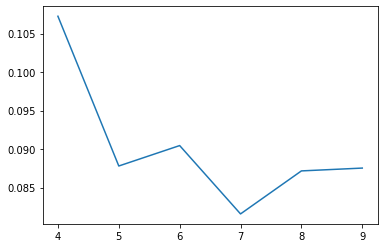

In [6]:
topics, representative_docs_dict = cluster_article(news_df['article'])

news_df['topic'] = topics
news_df['representative_docs'] = ""
news_df['representative_docs'].values[:] = 0

# print(representative_docs_dict)

for topics_index in representative_docs_dict:
    news_df['representative_docs'].iloc[topics_index] = 1
  

In [7]:
news_df.tail(1)

,id,article,category,company_id,reporter,timestamp,title,url_pattern,label,annotator,annotation_id,created_at,updated_at,lead_time,article_coref,people_name,ner,topic,representative_docs
99,855,"行政院長蘇貞昌昨(12日)在立法院會備詢時,用台語怒罵國民黨立委鄭麗文「不要臉」,引發藍營怒...",政治,3,楊蕓,1634091120,張亞中批蘇貞昌嗆鄭麗文不要臉 「歷任最失格的行政院長」,2100005,"[{""start"": 0, ""end"": 48, ""text"": ""行政院長蘇貞昌昨(12日...",1,9,2022-02-03T05:27:35.471495Z,2022-02-03T05:27:35.471520Z,303.946,"行政院長蘇貞昌昨(12日)在立法院會備詢時,用台語怒罵國民黨立委鄭麗文「不要臉」,引發藍營怒...","['朱子', '行政院長', '國民黨', '蘇貞昌', '張亞中', '蔡英文', '民進...","['朱子', '行政院長', '國民黨', '立法院會', '蘇貞昌', '行政院', '張...",0,0


In [8]:
topic_index = []
topic_article_index = []
topic_ner_dic = []

for i in range(max(topics)+1):
    topic_index.append(i)
    topic_article_index.append([])
    topic_ner_dic.append({})
# print(topic_ner_dic)
# print(max(topics))
# print(len(topic_ner_dic))

for i in range(len(news_df)):
    news_ner_list = ast.literal_eval(news_df.iloc[i]['ner'])
    for ner_name in news_ner_list:
        if ner_name in topic_ner_dic[news_df.iloc[i]['topic']].keys():
            topic_ner_dic[news_df.iloc[i]['topic']][ner_name] += 1
        else:
            topic_ner_dic[news_df.iloc[i]['topic']][ner_name] = 0
    topic_article_index[news_df.iloc[i]['topic']].append(i)

In [9]:
topic_info_df = pd.DataFrame(list(zip(topic_index,representative_docs_dict,topic_ner_dic)),columns=['topic_index','topic_represent_article','topic_ner_dic'])

In [10]:
topic_info_df.head(10)

,topic_index,topic_represent_article,topic_ner_dic
0,0,33,"{'鄭先': 0, '台灣': 67, '袂見': 5, '鄭麗文': 137, '陳明文'..."
1,1,75,"{'一': 4, '民進黨': 9, '丁特': 2, '時代力量': 0, '主丁特': ..."
2,2,39,"{'一': 35, '國慶日': 5, '蘇貞昌': 17, '台灣': 129, '民進黨..."
3,3,90,"{'台': 1, '蘇貞昌': 11, '第一': 16, '第二': 14, '五': 2..."


In [11]:
topic_info_df.to_csv(topic_info_file,index=False)

In [12]:
news_df.to_csv(all_output_file, index=False)